In [133]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from PyAstronomy import pyasl
from astropy.io import fits

In [135]:
# df  = pd.read_csv('combined_rvs_1.csv')
df  = pd.read_csv('full_combined_rvs_1.csv')
bjd = df['jd_drp']
rv_drp = df['rv_drp']*1000
σrv = df['σrv_drp']*1000
rv_template = df['rv_template']
# rv_by_order = df.iloc[:,75::2].values
# σrv_by_order = df.iloc[:,76::2].values
rv_by_order = df.iloc[:,164:].values * 1000
RV_gauss = np.loadtxt('./data_v4/RV_gauss.txt')

### Exclude bad observations

#### reject rvs outliers (outside 2-sigma)

In [138]:
def weighted_avg_and_std2(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    return (average, np.sqrt(variance))

In [139]:
_, rv_drp_std = weighted_avg_and_std2(rv_drp, 1/σrv**2)
rv_drp_median = np.median(rv_drp)
idx_rej_sigma = abs(rv_drp-rv_drp_median) > (2*rv_drp_std)
sum(idx_rej_sigma)

101

#### reject rvs on user-defined dates

In [140]:
dates_to_exclude = [datetime(2021, 6, 4), datetime(2021, 6, 16), datetime(2021, 7, 9), datetime(2021, 7, 10), datetime(2021, 7, 18), datetime(2021, 7, 19)]

idx_rej_bjd = np.zeros(bjd.shape, dtype=bool)

# use pyasl.jdcnv(date)+1 to translate to the corresponding bjd
for date in dates_to_exclude:
    idx = (abs(bjd-pyasl.jdcnv(date)-1)<0.5)
    idx_rej_bjd = idx_rej_bjd | idx
    
sum(idx_rej_bjd)

418

#### all rejects

In [141]:
idx_rej = idx_rej_sigma | idx_rej_bjd
len(idx_rej), sum(idx_rej)

(31795, 434)

### PDF

In [142]:
df.columns[164:]

Index(['CCFRV173', 'CCFRV172', 'CCFRV171', 'CCFRV170', 'CCFRV169', 'CCFRV168',
       'CCFRV167', 'CCFRV166', 'CCFRV165', 'CCFRV164',
       ...
       'CCFRV061', 'CCFRV060', 'CCFRV059', 'CCFRV058', 'CCFRV057', 'CCFRV056',
       'CCFRV055', 'CCFRV054', 'CCFRV053', 'CCFRV052'],
      dtype='object', length=122)

In [146]:
# version 3 (data_v3); index starting from 0
# title = [title[3:-9] for title in df.columns[75::2]]
# version 4 (data_v4)
title = np.array([int(title[-3:]) for title in df.columns[164:]])
print('all orders')
print(title)
o_start     = 55    # 56 in Julia
o_end       = 108   # 108 in julia
# o_exclude   = 173 - np.array([66, 67, 68, 69, 73, 74, 75, 76, 83, 118]) # -> version 3 (data_v3); index starting from 0
o_exclude   = 173 - np.array([66, 67, 68, 69, 73, 74, 75, 76, 78, 83, 107,108,112,113,117, 118]) # -> version 4 (data_v4);o_used      = np.array([x for x in np.arange(o_start, o_end) if (x in o_exclude) == False])
o_used      = np.array([x for x in np.arange(o_start, o_end) if ((x in o_exclude) == False) & (x in (173-o_plot))])
print('\norders used')
print(o_used) # order index 
o_used_physical = 173-o_used
print('\nphysical orders used')
o_used_physical

all orders
[173 172 171 170 169 168 167 166 165 164 163 162 161 160 159 158 157 156
 155 154 153 152 151 150 149 148 147 146 145 144 143 142 141 140 139 138
 137 136 135 134 133 132 131 130 129 128 127 126 125 124 123 122 121 120
 119 118 117 116 115 114 113 112 111 110 109 108 107 106 105 104 103 102
 101 100  99  98  97  96  95  94  93  92  91  90  89  88  87  86  85  84
  83  82  81  80  79  78  77  76  75  74  73  72  71  70  69  68  67  66
  65  64  63  62  61  60  59  58  57  56  55  54  53  52]

orders used
[57 58 59 62 63 64 67 68 71 72 73 74 75 76 77 78 80 81 82 83 84 91 92 94]

physical orders used


array([116, 115, 114, 111, 110, 109, 106, 105, 102, 101, 100,  99,  98,
        97,  96,  95,  93,  92,  91,  90,  89,  82,  81,  79])

In [147]:
if 0:
    def weighted_avg_and_std3(values, weights):
        """
        Return the weighted average and standard deviation.

        values, weights -- Numpy ndarrays with the same shape.
        """
        idx_no_nan = ~np.isnan(values)
        values = values[idx_no_nan]
        weights=weights[idx_no_nan]
        average = np.average(values, weights=weights)
        variance = np.average((values-average)**2, weights=weights)
        return (average, np.sqrt(variance))

    rv_mean_by_order = np.zeros(rv_by_order.shape[1])
    rv_std_by_order = np.zeros(rv_by_order.shape[1])
    for i in range(rv_by_order.shape[1]):
        rv_mean_by_order[i], rv_std_by_order[i] = weighted_avg_and_std3(rv_by_order[:,i], 1/σrv_by_order[:,i]**2)
        if int(title[i]) in o_used_physical:
            YN = ' '
        else:
            YN = 'x'    
        print(YN + ' %d\t%.2f'%(int(title[i]), rv_std_by_order[i]))
        
if 1:       
    def weighted_avg_and_std4(values, weights):
        """
        Return the weighted average and standard deviation.

        values, weights -- Numpy ndarrays with the same shape.
        """
        if sum(np.isnan(values))==len(values):
            return (np.nan, np.nan)
        else:
            idx_no_nan = ~np.isnan(values)
            values = values[idx_no_nan]
            weights=weights[idx_no_nan]
            average = np.average(values, weights=weights)
            variance = np.average((values-average)**2, weights=weights)
            return (average, np.sqrt(variance))
    
#     rv_mean_by_order = np.mean(rv_by_order, axis=1)
#     rv_std_by_order = np.std(rv_by_order, axis=1)

    rv_mean_by_order = np.zeros(rv_by_order.shape[1])
    rv_std_by_order = np.zeros(rv_by_order.shape[1])
    for i in range(rv_by_order.shape[1]):
        rv_mean_by_order[i], rv_std_by_order[i] = weighted_avg_and_std4(rv_by_order[~idx_rej,i], 1/σrv[~idx_rej]**2)
        if int(title[i]) in o_used_physical:
            YN = ' '
        else:
            YN = 'x'    
        print(YN + ' %d\t%.2f'%(int(title[i]), rv_std_by_order[i]))    

x 173	nan
x 172	nan
x 171	nan
x 170	nan
x 169	0.00
x 168	0.00
x 167	0.00
x 166	0.00
x 165	0.00
x 164	0.00
x 163	0.00
x 162	13.58
x 161	9.48
x 160	10.58
x 159	6.14
x 158	5.06
x 157	3.80
x 156	7.33
x 155	3.44
x 154	3.28
x 153	2.65
x 152	2.73
x 151	2.49
x 150	2.53
x 149	2.27
x 148	2.48
x 147	2.30
x 146	2.37
x 145	2.18
x 144	2.25
x 143	2.06
x 142	2.19
x 141	2.21
x 140	2.13
x 139	2.22
x 138	2.03
x 137	2.03
x 136	2.27
x 135	1.83
x 134	2.22
x 133	2.02
x 132	1.95
x 131	2.03
x 130	2.10
x 129	2.05
x 128	2.06
x 127	2.37
x 126	2.12
x 125	2.03
x 124	1.95
x 123	1.66
x 122	1.83
x 121	6.90
x 120	1.90
x 119	1.72
x 118	6.11
x 117	2.51
  116	2.05
  115	2.01
  114	2.13
x 113	2.89
x 112	3.00
  111	2.24
  110	2.05
  109	2.41
x 108	3.48
x 107	4.45
  106	2.80
  105	3.01
x 104	0.00
x 103	0.00
  102	2.91
  101	2.91
  100	2.20
  99	2.20
  98	2.29
  97	8.48
  96	3.39
  95	3.50
x 94	0.00
  93	8.09
  92	3.80
  91	3.93
  90	5.78
  89	7.35
x 88	0.00
x 87	0.00
x 86	0.00
x 85	0.00
x 84	0.00
x 83	23.10
  82	4.11
  81	3.

In [148]:
idx_plot = (~np.isnan(rv_mean_by_order)) & (rv_mean_by_order!=0)
o_plot = title[idx_plot]
o_plot

array([162, 161, 160, 159, 158, 157, 156, 155, 154, 153, 152, 151, 150,
       149, 148, 147, 146, 145, 144, 143, 142, 141, 140, 139, 138, 137,
       136, 135, 134, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124,
       123, 122, 121, 120, 119, 118, 117, 116, 115, 114, 113, 112, 111,
       110, 109, 108, 107, 106, 105, 102, 101, 100,  99,  98,  97,  96,
        95,  93,  92,  91,  90,  89,  83,  82,  81,  79,  78])

In [149]:
if 0:
    import seaborn as sns
    fig, axes = plt.subplots(figsize=(15, 3))
    for i in range(rv_by_order.shape[1]):
        if int(title[i]) in o_used_physical:
            sns.distplot(rv_by_order[~idx_rej,i], hist=True, kde=True, 
                         kde_kws={'linewidth': 2})
    plt.xlim(-25, 25)    
    plt.show()

    fig, axes = plt.subplots(figsize=(15, 3))
    for i in range(rv_by_order.shape[1]):
        sns.distplot(rv_by_order[idx_rej,i], hist=True, kde=True, 
                     kde_kws={'linewidth': 2})
    plt.xlim(-25, 25)    
    plt.show()

### Plot RVs by order

(122, 1604)


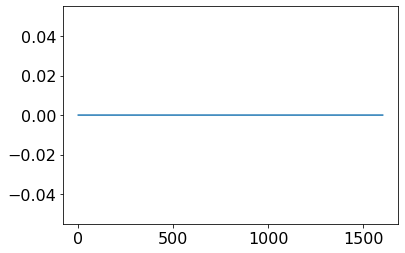

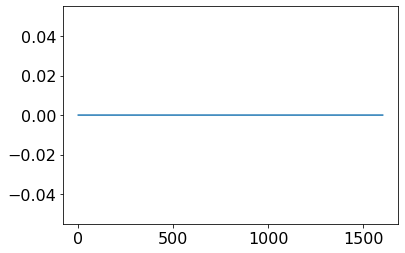

In [150]:
#what happens to nan 
print(ccf_per_order.shape)

#173 - nan 
plt.plot(ccf_per_order[0,:])
plt.show()
# 169 - 0.0
plt.plot(ccf_per_order[4,:])
plt.show()


mean rv = 153.64; std rv = 13.58


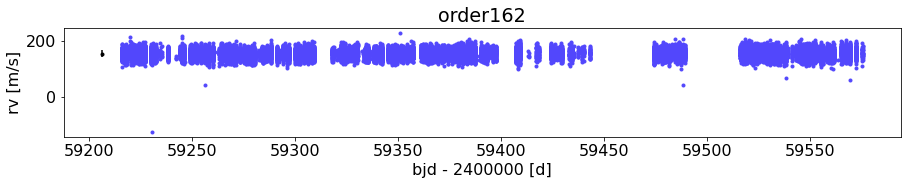

mean rv = 43.32; std rv = 9.48


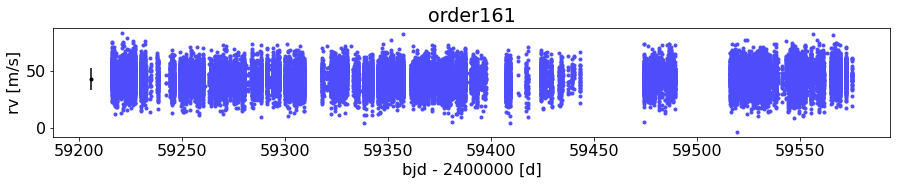

mean rv = -118.82; std rv = 10.58


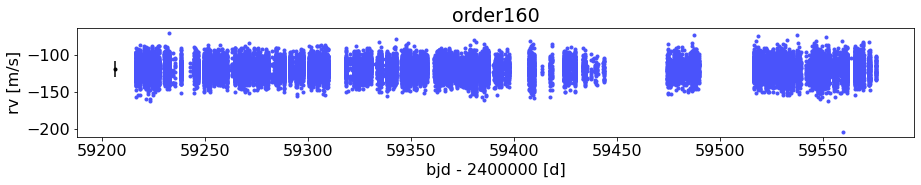

mean rv = -9.36; std rv = 6.14


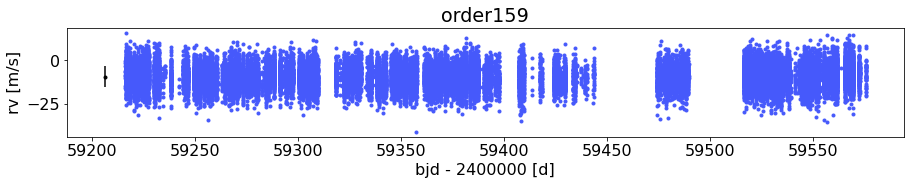

mean rv = 224.79; std rv = 5.06


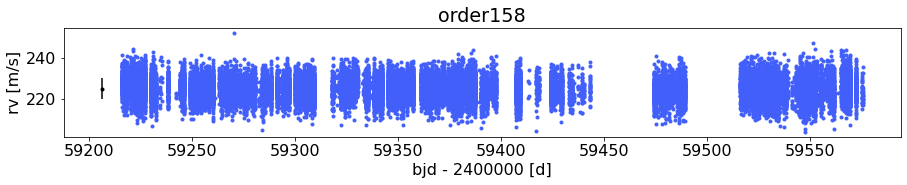

mean rv = 79.21; std rv = 3.80


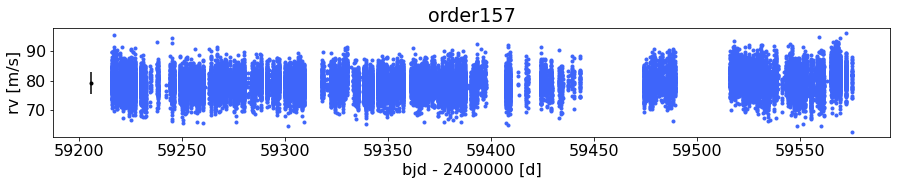

mean rv = 86.02; std rv = 7.33


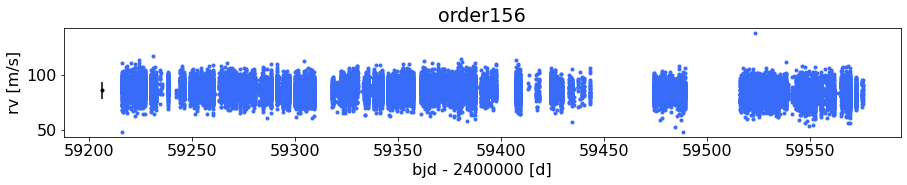

mean rv = 60.31; std rv = 3.44


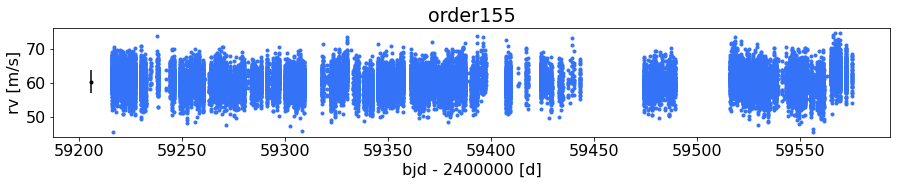

mean rv = 17.52; std rv = 3.28


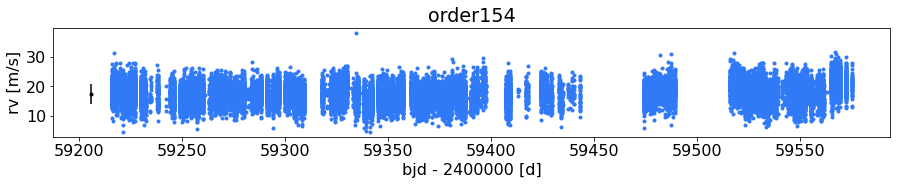

mean rv = 94.07; std rv = 2.65


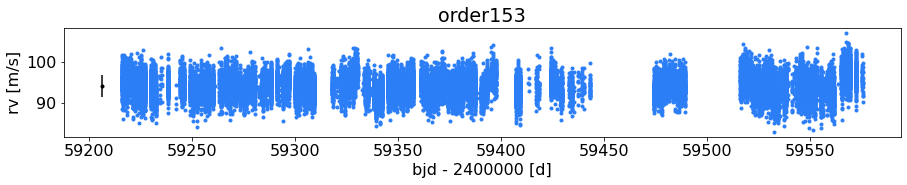

mean rv = -76.47; std rv = 2.73


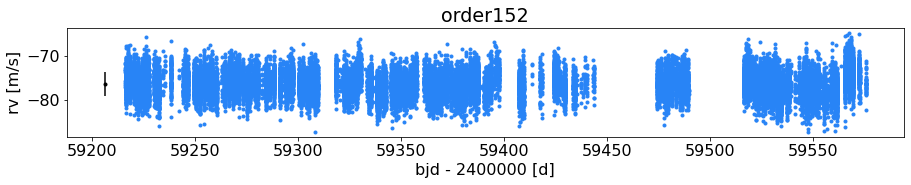

mean rv = 34.02; std rv = 2.49


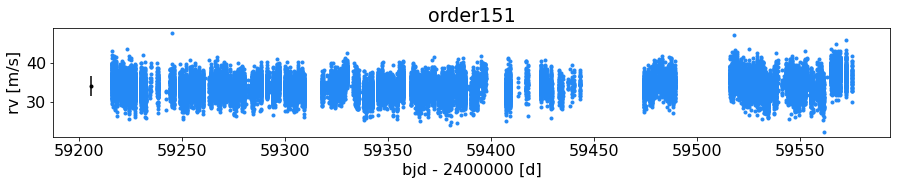

mean rv = -38.97; std rv = 2.53


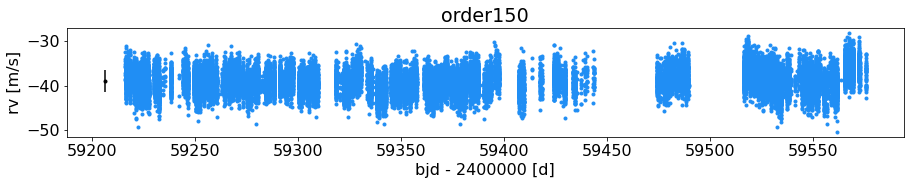

mean rv = 54.17; std rv = 2.27


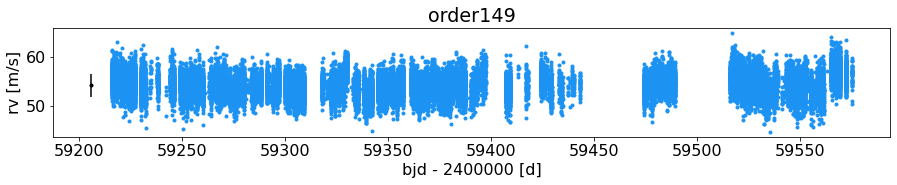

mean rv = 2.43; std rv = 2.48


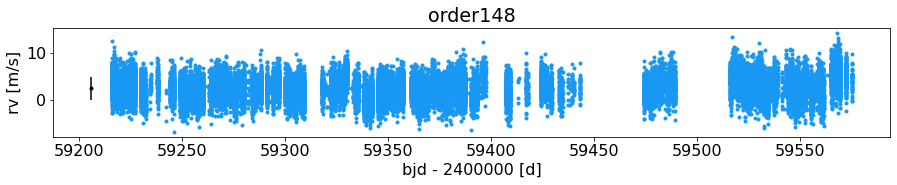

mean rv = -73.34; std rv = 2.30


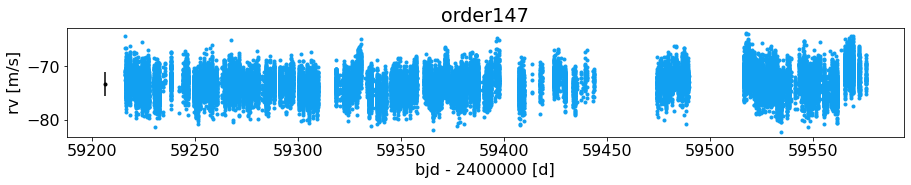

mean rv = -165.23; std rv = 2.37


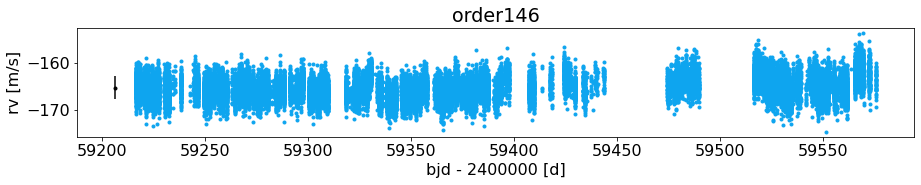

mean rv = 11.82; std rv = 2.18


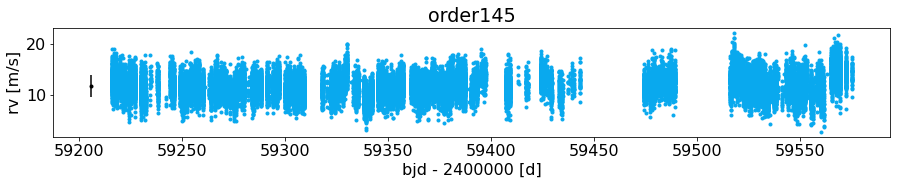

mean rv = -30.99; std rv = 2.25


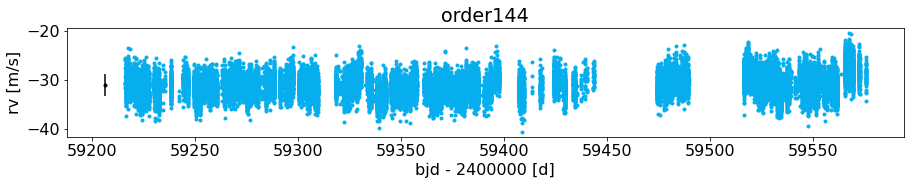

mean rv = 35.93; std rv = 2.06


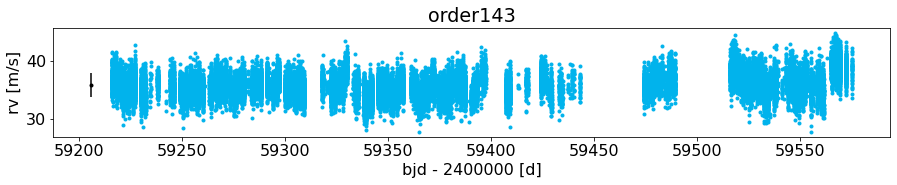

mean rv = 90.73; std rv = 2.19


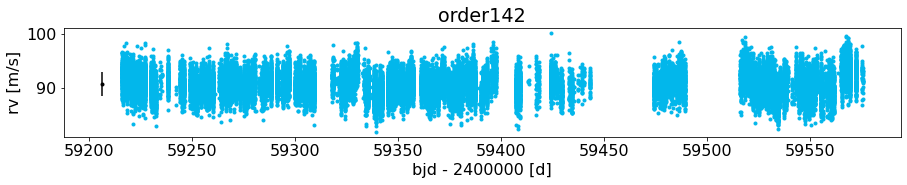

mean rv = 107.55; std rv = 2.21


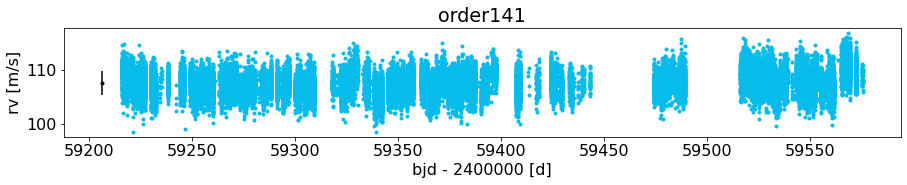

mean rv = 116.71; std rv = 2.13


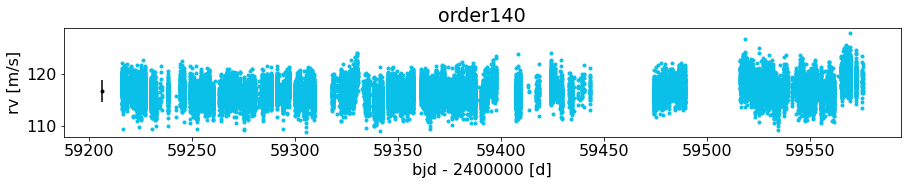

mean rv = 51.86; std rv = 2.22


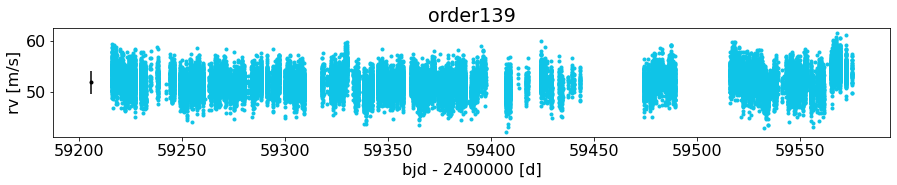

mean rv = 10.13; std rv = 2.03


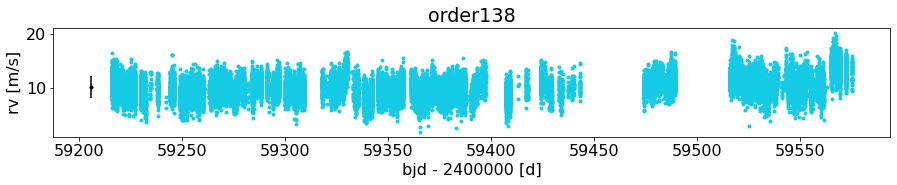

mean rv = 86.84; std rv = 2.03


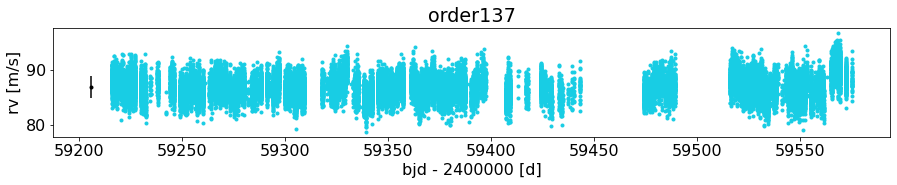

mean rv = 84.93; std rv = 2.27


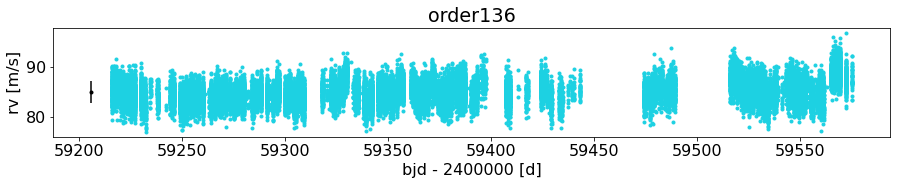

mean rv = -30.49; std rv = 1.83


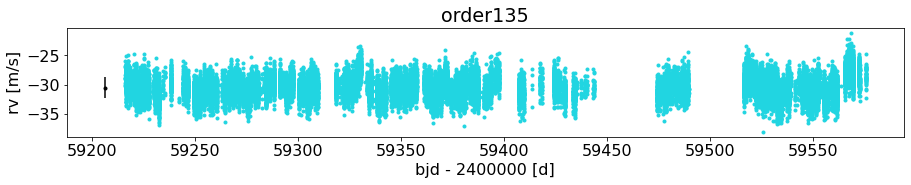

mean rv = 54.96; std rv = 2.22


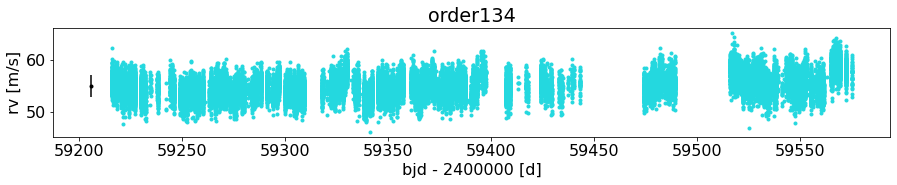

mean rv = -19.32; std rv = 2.02


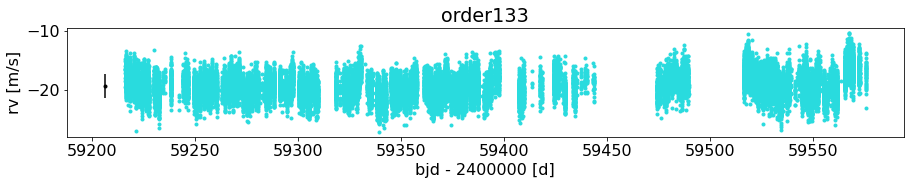

mean rv = 56.17; std rv = 1.95


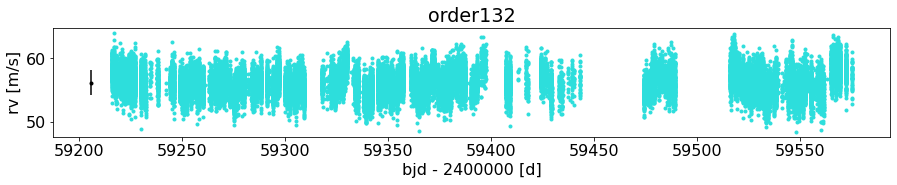

mean rv = 18.92; std rv = 2.03


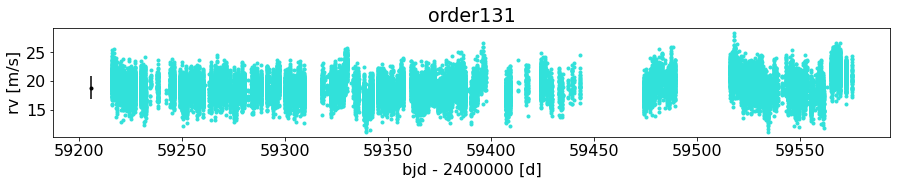

mean rv = -39.06; std rv = 2.10


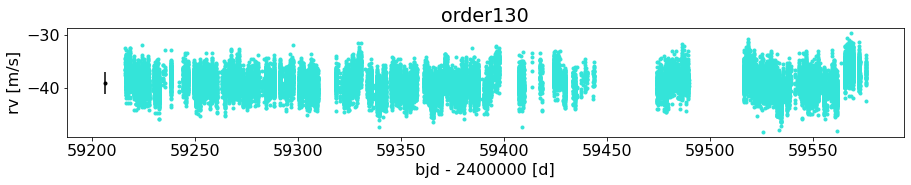

mean rv = 19.79; std rv = 2.05


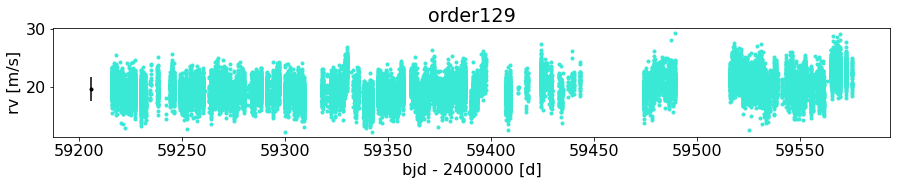

mean rv = 12.90; std rv = 2.06


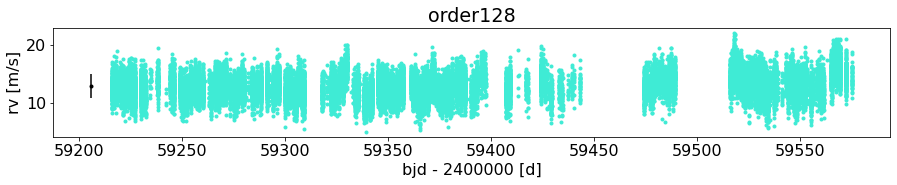

mean rv = 39.72; std rv = 2.37


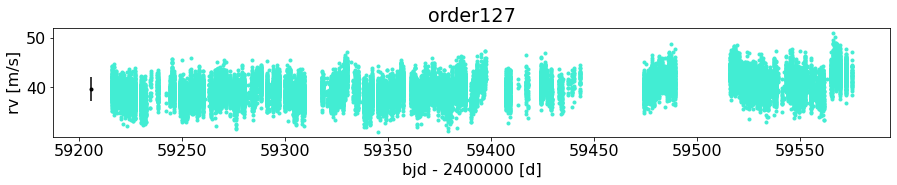

mean rv = -6.61; std rv = 2.12


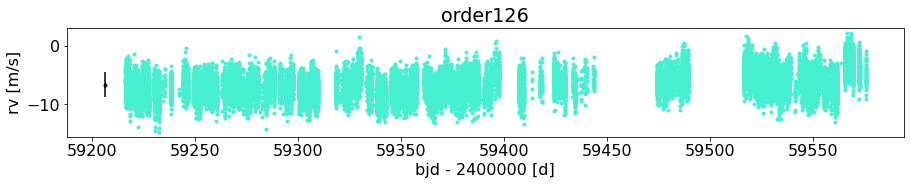

mean rv = 35.18; std rv = 2.03


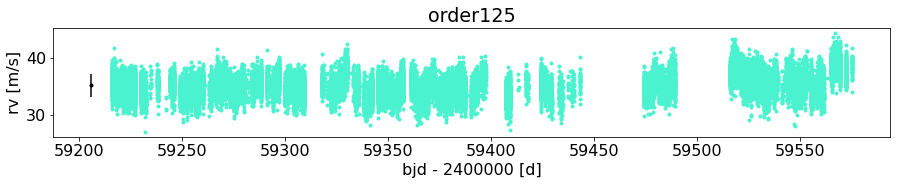

mean rv = -66.88; std rv = 1.95


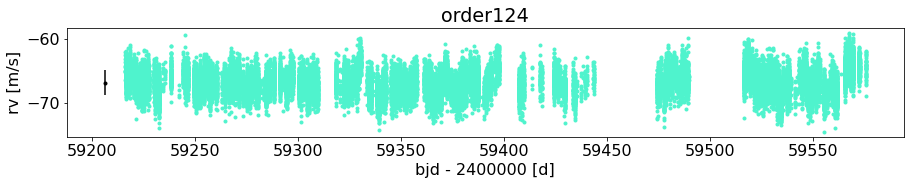

mean rv = 22.23; std rv = 1.66


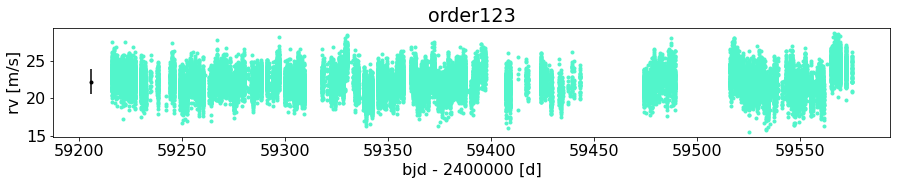

mean rv = 66.37; std rv = 1.83


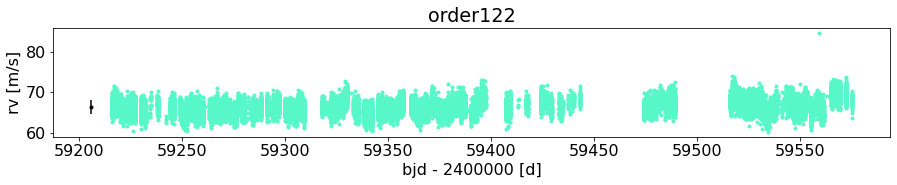

mean rv = -67.32; std rv = 6.90


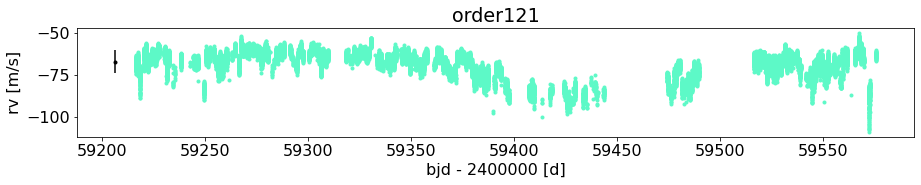

mean rv = -141.17; std rv = 1.90


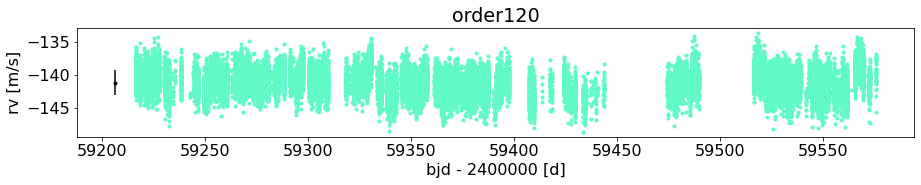

mean rv = -11.51; std rv = 1.72


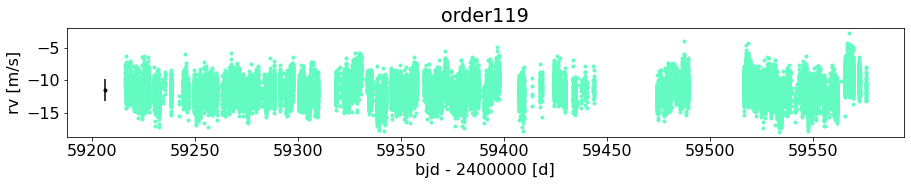

mean rv = 73.19; std rv = 6.11


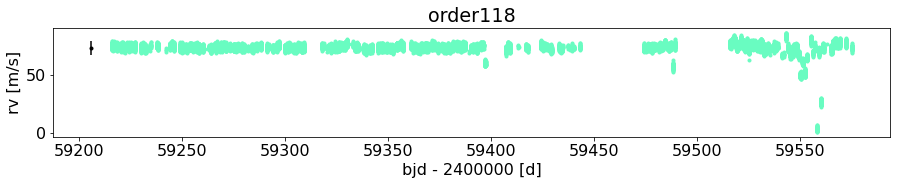

mean rv = 59.22; std rv = 2.51


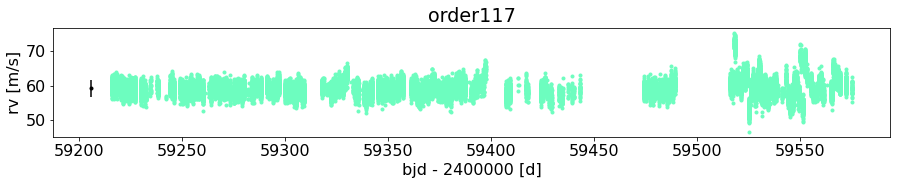

mean rv = -178.93; std rv = 2.05


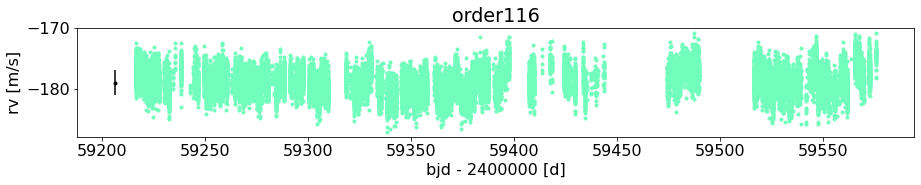

mean rv = 83.58; std rv = 2.01


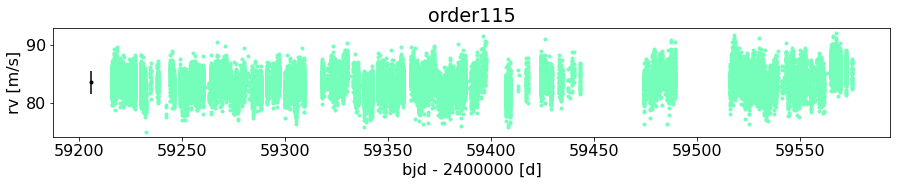

mean rv = -83.05; std rv = 2.13


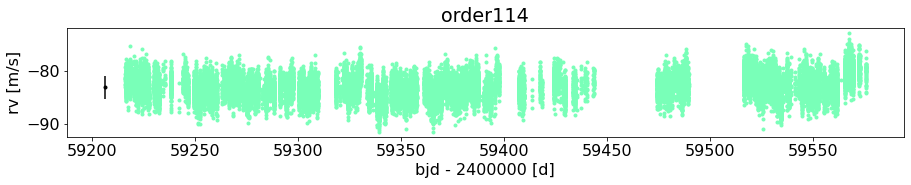

mean rv = -35.34; std rv = 2.89


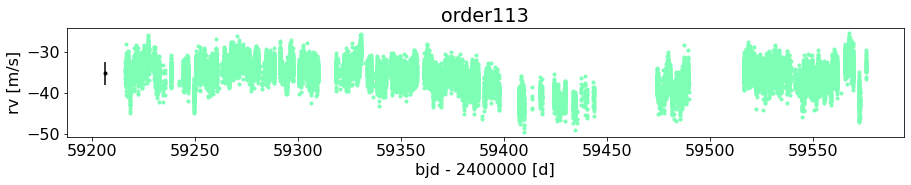

mean rv = -134.19; std rv = 3.00


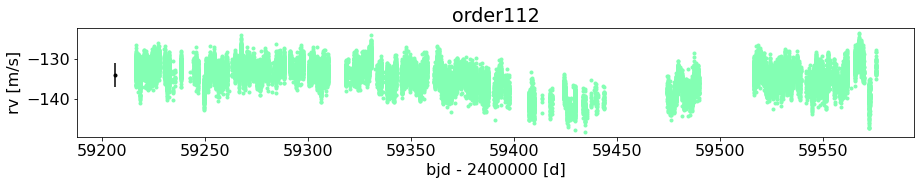

mean rv = 42.21; std rv = 2.24


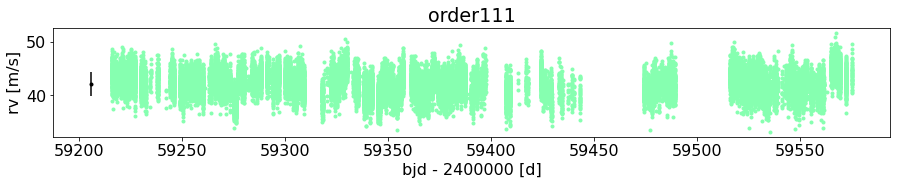

mean rv = -34.94; std rv = 2.05


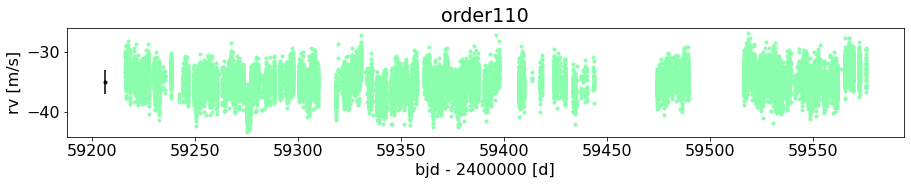

mean rv = 62.69; std rv = 2.41


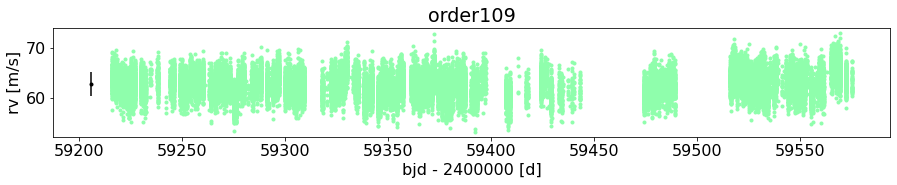

mean rv = -17.81; std rv = 3.48


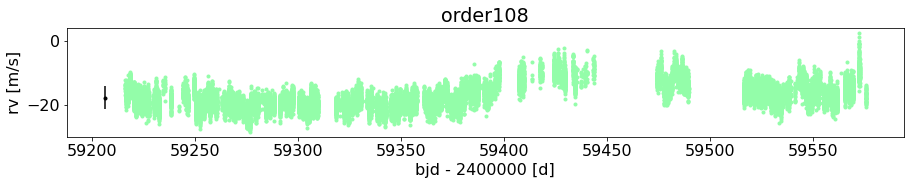

mean rv = -37.77; std rv = 4.45


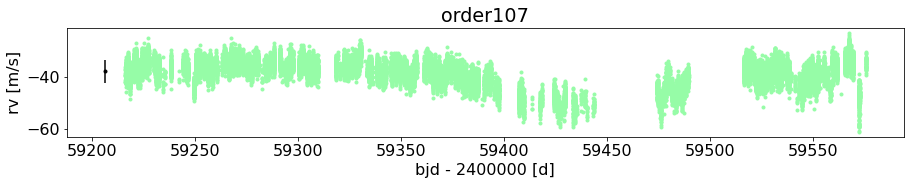

mean rv = -21.18; std rv = 2.80


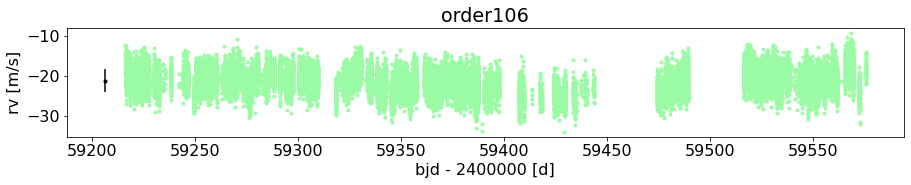

mean rv = -24.73; std rv = 3.01


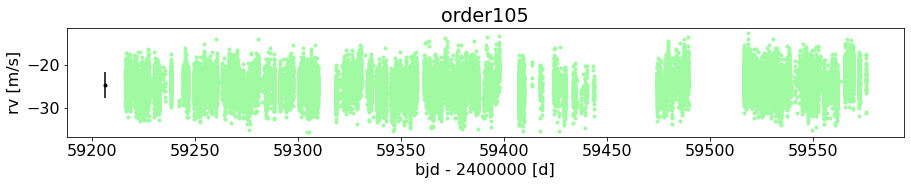

mean rv = -94.81; std rv = 2.91


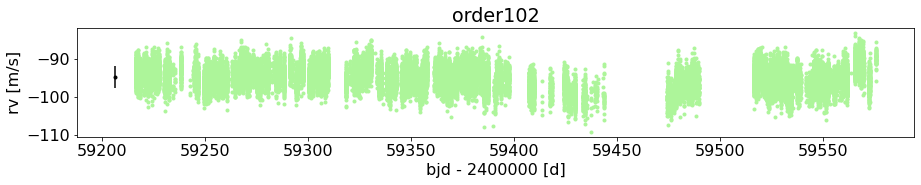

mean rv = 20.93; std rv = 2.91


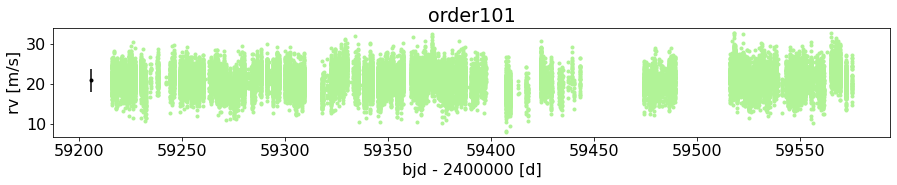

mean rv = -12.83; std rv = 2.20


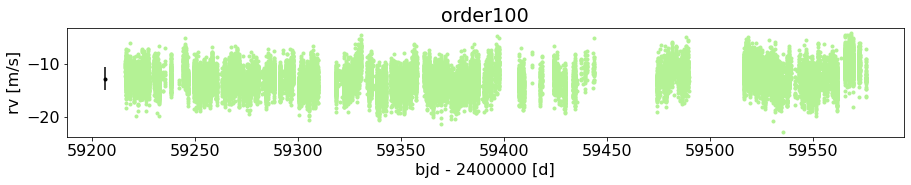

mean rv = 4.28; std rv = 2.20


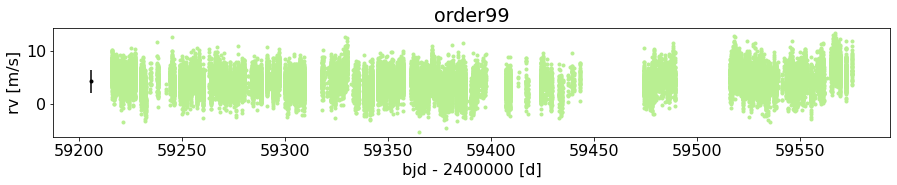

mean rv = -29.02; std rv = 2.29


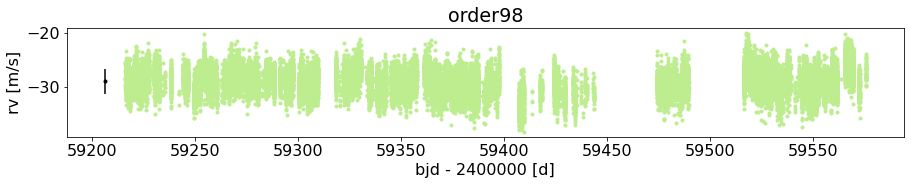

mean rv = 0.40; std rv = 8.48


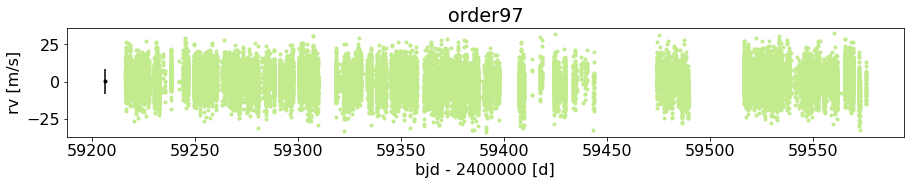

mean rv = -46.58; std rv = 3.39


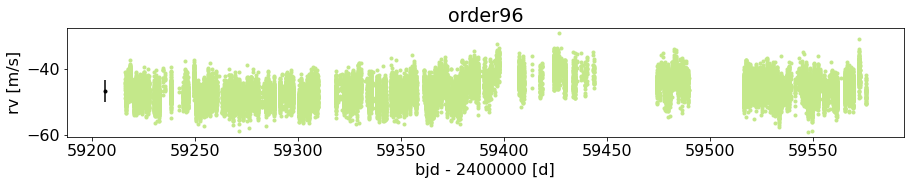

mean rv = 21.02; std rv = 3.50


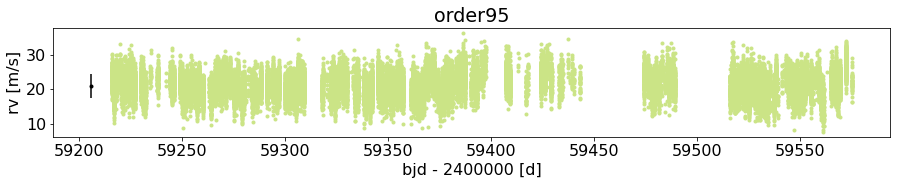

mean rv = 19.01; std rv = 8.09


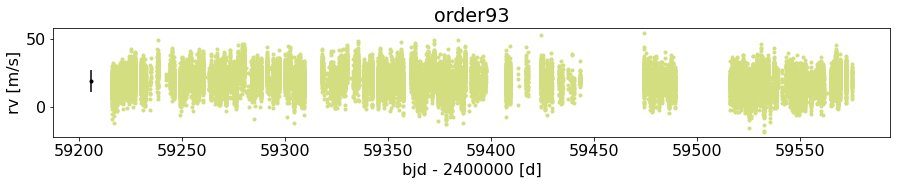

mean rv = -2.03; std rv = 3.80


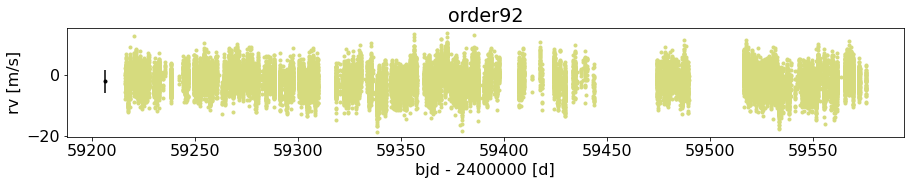

mean rv = -5.72; std rv = 3.93


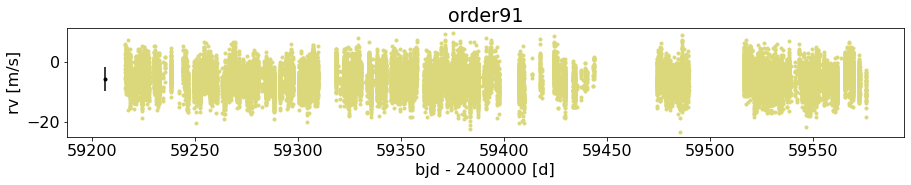

mean rv = -3.35; std rv = 5.78


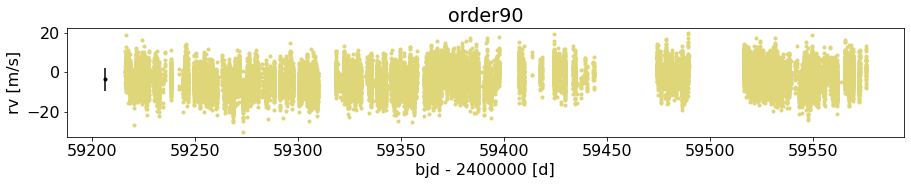

mean rv = -12.12; std rv = 7.35


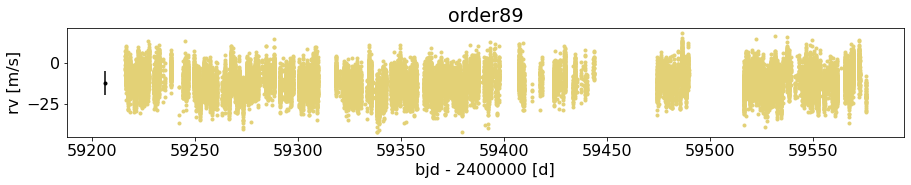

mean rv = 198185.02; std rv = 23.10


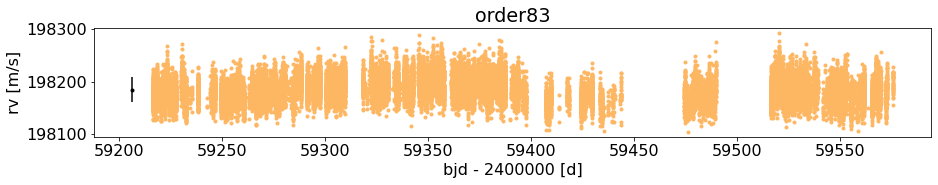

mean rv = 23.97; std rv = 4.11


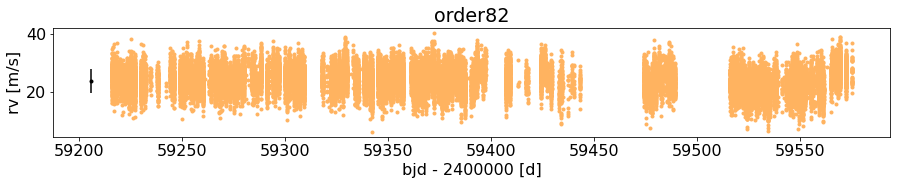

mean rv = -18.70; std rv = 3.69


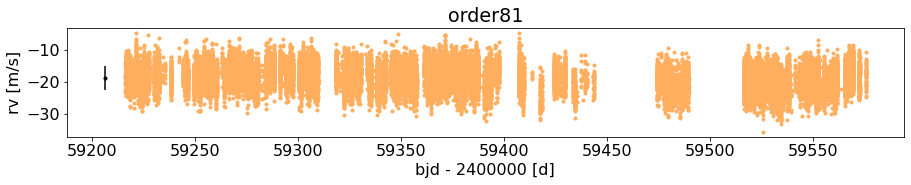

mean rv = -12.11; std rv = 5.89


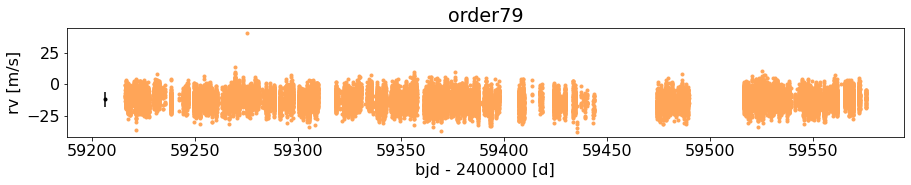

mean rv = -10.50; std rv = 7.80


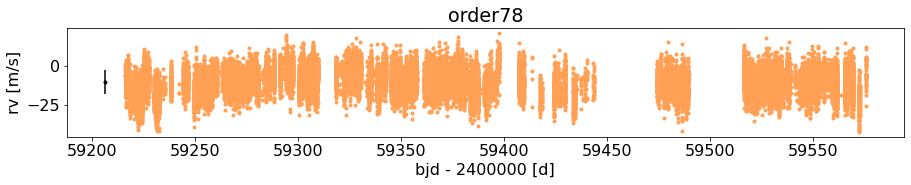

In [121]:
if 0:
    import matplotlib.cm as cm
    colors = cm.rainbow(np.linspace(0, 1, rv_by_order.shape[1]))
    title = [title[3:-9] for title in df.columns[75::2]]
    idx_nan_all = np.zeros(sum(~idx_rej), dtype=bool)

    for i in range(rv_by_order.shape[1]):
    # for i in range(3):    
        fig, axes = plt.subplots(figsize=(15, 2))

        # plot rvs by order
        plt.plot(bjd[~idx_rej]-2400000, rv_by_order[~idx_rej,i], '.', alpha=0.01, color=colors[i])

        # label nan values 
        idx_nan = np.isnan(rv_by_order[~idx_rej,i]) | np.isnan(σrv_by_order[~idx_rej,i])
        if sum(idx_nan) == 0:
            plt.title('order' + title[i], color='black')
        else:
            idx_nan_all = idx_nan_all | idx_nan
            Tage = pyasl.daycnv(bjd[~idx_rej][idx_nan])
            print(list(set(['%d-%d-%d' %tuple(einTag)[:3] for einTag in Tage])))
            print('#nan_rv = %d' %sum(idx_nan))
            plt.title('order' + title[i], color='r')
            plt.plot(bjd[~idx_rej][idx_nan]-2400000, np.zeros(sum(idx_nan)), 'rs', mfc='none', mew=3)

        # print median rv and σrv per order
        median_rv = np.median(rv_by_order[~idx_rej,i][~idx_nan])
        median_σrv = np.median(σrv_by_order[~idx_rej,i][~idx_nan])
        plt.errorbar(bjd[0]-2400000-10, median_rv, median_σrv, marker='.', c='black')
        print("median rv = %.2f; median σrv = %.2f" %(median_rv, median_σrv))

        plt.xlabel('bjd - 2400000 [d]')
        plt.ylabel('rv [m/s]')
        plt.show()

        # check if the corresponding order in the fits files have 0 flux
        if sum(idx_nan) != 0:
            files = df[df['jd_drp'].isin(bjd[~idx_rej][idx_nan])]['Filename']
            yn = True
            for file in files:
                with fits.open(file) as hdulist:
                    ccf_per_order = hdulist[12].data
                    plt.plot(-100 + np.arange(ccf_per_order.shape[1])*0.25, ccf_per_order[173-int(title[i]),:], alpha=0.5)
            plt.xlabel('v [km/s]')
            plt.ylabel('ccf')
            plt.show()
            
if 1:
    import matplotlib.cm as cm
    plt.rcParams.update({'font.size': 16})
    colors = cm.rainbow(np.linspace(0, 1, rv_by_order.shape[1]))
    idx_nan_all = np.zeros(sum(~idx_rej), dtype=bool)

    for i in range(rv_by_order.shape[1]):
#     for i in range(20):    
        if int(title[i]) in o_plot:
            fig, axes = plt.subplots(figsize=(15, 2))

            # plot rvs by order
            plt.plot(bjd[~idx_rej]-2400000, rv_by_order[~idx_rej,i]-np.mean(rv_drp), '.', alpha=1, color=colors[i])

            # label nan values 
            idx_nan = np.isnan(rv_by_order[~idx_rej,i])
            if sum(idx_nan) == 0:
                plt.title('order' + str(title[i]), color='black')
            else:
                idx_nan_all = idx_nan_all | idx_nan
                Tage = pyasl.daycnv(bjd[~idx_rej][idx_nan])
                print(list(set(['%d-%d-%d' %tuple(einTag)[:3] for einTag in Tage])))
                print('#nan_rv = %d' %sum(idx_nan))
                plt.title('order' + title[i], color='r')
                plt.plot(bjd[~idx_rej][idx_nan]-2400000, np.zeros(sum(idx_nan)), 'rs', mfc='none', mew=3)

            # print median rv and std rv per order
            mean_rv, std_rv = weighted_avg_and_std4(rv_by_order[~idx_rej,i], 1/σrv[~idx_rej]**2) 
            plt.errorbar(bjd[0]-2400000-10, mean_rv-np.mean(rv_drp), std_rv, marker='.', c='black')
            print("mean rv = %.2f; std rv = %.2f" %(mean_rv-np.mean(rv_drp), std_rv))

            plt.xlabel('bjd - 2400000 [d]')
            plt.ylabel('rv [m/s]')
            plt.show()

All dates with nan

In [125]:
Tage_mit_nan = pyasl.daycnv(bjd[~idx_rej][idx_nan_all])
print(list(dict.fromkeys(['%d-%d-%d' %tuple(einTag)[:3] for einTag in Tage_mit_nan])))
print('#nan = %d' %sum(idx_nan_all))

[]
#nan = 0


### RV comparison

In [14]:
if 0:
    fig, axes = plt.subplots(figsize=(15, 3))
    alpha=0.1

    plt.plot(bjd[~idx_rej]-2400000, rv_drp[~idx_rej]-rv_drp[0], '.', label='rv_drp', alpha=alpha)
    plt.plot(bjd[~idx_rej]-2400000, rv_template[~idx_rej]-rv_template[0]-10, '.', label='rv_template', alpha=alpha)
    plt.plot(bjd[~idx_rej]-2400000, RV_gauss[~idx_rej]-RV_gauss[0]-20, '.', label='RV_gauss', alpha=alpha)

    plt.legend()
    plt.xlabel('BJD - 2400000 [d]')
    plt.ylabel('m/s')
    plt.show()

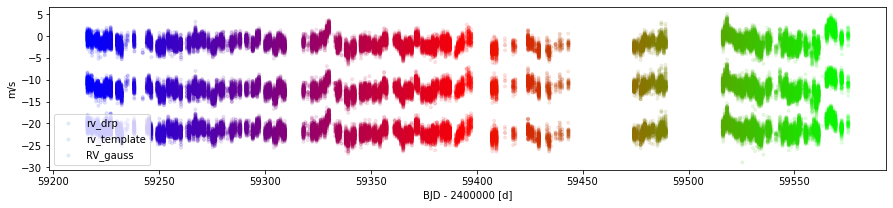

In [15]:
fig, axes = plt.subplots(figsize=(15, 3))
alpha=0.1

bjd_acc = bjd[~idx_rej]
colour = (bjd_acc - min(bjd_acc)) / (max(bjd_acc) - min(bjd_acc))
plt.scatter(bjd_acc-2400000, rv_drp[~idx_rej]-rv_drp[0], marker='.', label='rv_drp', alpha=alpha, c=colour, cmap=plt.cm.brg)
plt.scatter(bjd_acc-2400000, rv_template[~idx_rej]-rv_template[0]-10, marker='.', label='rv_template', alpha=alpha, c=colour, cmap=plt.cm.brg)
plt.scatter(bjd_acc-2400000, RV_gauss[~idx_rej]-RV_gauss[0]-20, marker='.', label='RV_gauss', alpha=alpha, c=colour, cmap=plt.cm.brg)

plt.legend()
plt.xlabel('BJD - 2400000 [d]')
plt.ylabel('m/s')
plt.show()

RV difference 

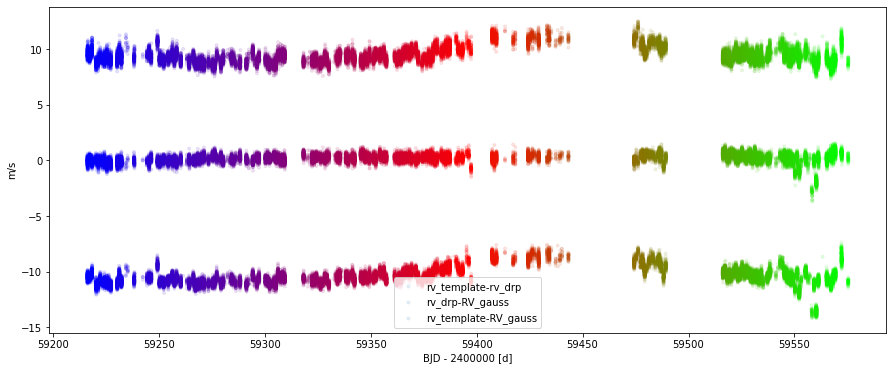

In [16]:
fig, axes = plt.subplots(figsize=(15, 6))
alpha=0.1

plt.scatter(bjd_acc-2400000, (rv_template[~idx_rej]-rv_template[0]) - (rv_drp[~idx_rej]-rv_drp[0])+10, marker='.', label='rv_template-rv_drp', alpha=alpha, c=colour, cmap=plt.cm.brg)
plt.scatter(bjd_acc-2400000, (rv_drp[~idx_rej]-rv_drp[0]) - (RV_gauss[~idx_rej]-RV_gauss[0]), marker='.', label='rv_drp-RV_gauss', alpha=alpha, c=colour, cmap=plt.cm.brg)
plt.scatter(bjd_acc-2400000, (rv_template[~idx_rej]-rv_template[0]) - (RV_gauss[~idx_rej]-RV_gauss[0])-10, marker='.', label='rv_template-RV_gauss', alpha=alpha, c=colour, cmap=plt.cm.brg)

plt.legend()
plt.xlabel('BJD - 2400000 [d]')
plt.ylabel('m/s')
plt.show()

In [17]:
if 0:
    plt.scatter(rv_drp[~idx_rej], rv_template[~idx_rej], marker='.', c=colour, cmap=plt.cm.brg, alpha=0.02)
    plt.plot([min(rv_drp[~idx_rej]), max(rv_drp[~idx_rej])], [min(rv_template[~idx_rej]), max(rv_template[~idx_rej])], 'k-')
    plt.xlabel('rv_drp')
    plt.ylabel('rv_template')
    plt.show()

    plt.scatter(rv_drp[~idx_rej], RV_gauss[~idx_rej], marker='.', c=colour, cmap=plt.cm.brg, alpha=0.02)
    plt.plot([min(rv_drp[~idx_rej]), max(rv_drp[~idx_rej])], [min(RV_gauss[~idx_rej]), max(RV_gauss[~idx_rej])], 'k-')
    plt.xlabel('rv_drp')
    plt.ylabel('RV_gauss')
    plt.show()

    plt.scatter(rv_template[~idx_rej], RV_gauss[~idx_rej], marker='.', c=colour, cmap=plt.cm.brg, alpha=0.02)
    plt.plot([min(rv_template[~idx_rej]), max(rv_template[~idx_rej])], [min(RV_gauss[~idx_rej]), max(RV_gauss[~idx_rej])], 'k-')
    plt.xlabel('rv_template')
    plt.ylabel('RV_gauss')
    plt.show()